## Random Fourier Features based SLAM: Experiments

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from random_features import RFF

from data_utils import Landscape
from data_utils import Odometry
from model import Model
from observation import RangeModel 
from data_utils import get_prediction

In [2]:
def APE_trans(true_states, model_states):
    return np.sqrt(np.linalg.norm(model_states[:, :2] / true_states[:, :2]) ** 2 / len(true_states))

In [3]:
def APE_rot(true_states, model_states):
    return np.sqrt(np.linalg.norm(model_states[:, 2] / true_states[:, 2]) ** 2 / len(true_states))

### Replication of graphs from the paper

In [4]:
np.random.seed(42)

In [5]:
def train_range_only(n_features = 100, num_landmarks = 20, N_pts = 100, 
                     observation_dim = 3, max_time = 10, beta = np.array([1.0, 1.0])):
    
    # Set RFF sampler
    sampler = lambda shape: multivariate_normal(mean = [0], 
                                                cov = (1./3**2) * np.eye(1)).rvs(size = np.product(shape))
    assert n_features % 2 == 0
    rff = RFF(n_features = n_features // 2, w_sampler=sampler, dim=1)

    # Set landscape
    landscape = Landscape(num_landmarks = num_landmarks)
    landscape.initialize()

    # Odometry
    odometry = Odometry(landscape, observation_dim = observation_dim, max_time = max_time, beta = beta)
    odometry.generate(N_pts)
    
    def prior_mean(t, state_estimates):
        i = odometry.times.index(t)
        state = get_prediction(state_estimates[i], odometry.motions[i])
        return state
    
    range_model = RangeModel(odometry.Q[0, 0])
    initial_values = np.concatenate([np.zeros(n_features * 3), landscape.landmarks.reshape(-1)])
    b_means = np.concatenate([np.zeros(n_features * 3), landscape.landmarks.reshape(-1)])

    model = Model(rff=rff, 
                  initial_values=initial_values,
                  initial_state=odometry.states[0],
                  times=odometry.times,
                  measurements=np.stack(odometry.observations, 0)[:, 0, [0, 2]],
                  measurement_covs=[odometry.Q[:1, :1]]*N_pts,
                  motions=odometry.motions,
                  b_means=b_means,
                  b_covs=[0.01*np.eye(n_features)]*3,
                  land_means=landscape.landmarks,
                  land_cov=[0.01*np.eye(2)]*len(landscape.landmarks),
                  observation_model=range_model,
                  prior_mean=prior_mean,
                  dampening_factor=0.01)
    
    model.run_slam(100)
    return np.array(odometry.states[1:]), np.array(model.states)

In [6]:
results_trans = np.zeros((5, 4))
results_rot = np.zeros((5, 4))

i, j = 0, 0
for noise in [1, 2, 3, 4, 5]:
    for num_landmarks in [5, 10, 20, 30]:
        true_st, mod_st = train_range_only(n_features = 100, num_landmarks = num_landmarks)
        results_trans[i, j] = APE_trans(true_st, mod_st)
        results_rot[i, j] = APE_rot(true_st, mod_st)
        j += 1
    i+= 1
    j = 0

0.5400256825175792
0.16109148633017814
0.18481864127455552
0.15401132810588722
0.12361699017488148
0.123448664369482
0.0874000915340155
0.08796883559081665
0.07645704600039621
0.07478208880809056
0.06187807668909575
0.059135010756382465
0.05502335555612438
0.048415748149877064
0.04745135541623318
0.04248690664911082
0.04077285930146706
0.03860533307976443
0.040525198375658066
0.04562831472149662
0.03685371235330504
0.04657452900946588
0.04165999389069675
0.039716564566021975
0.0375375955203184
0.03207586901356986
0.03356920643085147
0.04328684828892713
0.03687776908495414
0.039684754891628087
0.03682871564693687
0.03667864347418189
0.038008736352699246
0.04479645276841548
0.03723770679703328
0.03322158351814311
0.0281356441943682
0.03500622328179016
0.05157429796980463
0.03660900428203512
0.035564442374690454
0.04352695647195951
0.04497067487945002
0.041700636423960546
0.034275185314531095
0.028497805444317983
0.02952086760511288
0.0329888829625733
0.03137269024806305
0.029525355738551

0.45451039637981816
0.4420020793276761
0.4651039122974149
0.4854891512847597
0.4285800787420089
0.41995839292704
0.40655239657683445
0.4030007537010201
0.4090268629106203
0.345078562953285
0.4504797449329491
0.3618487528480263
0.3486167984432801
0.3113191618981264
0.33474445157939864
0.36637962434483645
0.3286930628576918
0.36330250615611515
0.37534957613240844
0.3179332782366233
0.2949029986460548
0.2917440046388403
0.298749372632251
0.312735493577372
0.31981323095281533
0.28934104269330396
0.25979068113541137
0.27795739781248285
0.2657230122161391
0.30273767591252754
0.2690591107500117
0.2584009221900642
0.2730109457571613
0.24419584083941476
0.24489599553094163
0.26150297590547117
0.2590197304633665
0.2716947889263495
0.27086107218774774
0.2742178197508401
0.2729352879819886
0.26310125787113503
0.2616541749562364
0.2358162241312155
0.25329235349184764
0.2646620235698949
0.2572846504771802
0.26054996008469855
0.27490552716433947
0.30602930962202407
0.2670101686000689
0.26324158359414

1.143109090980134
1.2107370213863538
1.1121075193756698
0.938658944489759
0.8837930119714197
0.9299040715125824
0.8861358399696787
0.8631951209668896
0.927409523922732
1.014711727219904
1.0045899963226221
1.084164170738469
1.121022777057617
1.1698475862099758
0.9868993034206123
1.0347122994016387
1.0311710074637734
1.3519273269178227
0.9297915291794239
0.967367343526206
1.042116798204589
1.262625063009112
1.081611541533134
1.2891881820639304
0.9011623161295609
1.0298259269997339
1.0378368318262579
1.3769780648390921
1.7562122719039321
1.315429349422488
0.8629479598216553
1.255201552357996
1.3794901267619841
1.3257456801636205
1.2643806209082866
1.18268601366113
1.1918697109469973
1.2196622730330684
1.1998901665858162
1.1655340294038694
1.1125998817010958
0.9422878291029867
1.2118555778974167
1.238404396447872
1.1977608736939438
1.1844915306461643
1.1953059659799135
1.1643942519978634
1.2606352560219882
0.9954290445156503
0.9675713593132522
1.1940013868595798
0.9869573645862093
1.017188

0.2043842270639946
0.2030982327419316
0.2358063919592883
0.20636401647193175
0.2029654361211646
0.2045523693241081
0.20158761496482447
0.21838623792113318
0.21519530686359054
0.24536305999442973
0.16872055547419
0.22215221849357825
0.21915186288380953
0.19729125217642812
0.20108518921204413
0.17333799577540512
0.1927733743872188
0.20159261444012122
0.18924046321492005
0.19143565842140006
0.17649911538811383
0.16812384453193027
0.154187419176557
0.14857989617983586
0.13874977574199404
0.14114285951798897
0.13510576497276888
0.13315431944168482
0.13131319123464943
0.11888400843561571
0.11308290002580641
0.111689491437582
0.09374049403074972
0.11241666088415601
0.09668976001621317
0.08466794164628931
0.08809704038136112
0.08088960936939439
0.07538641870506288
0.06713880630273657
0.05950871076020198
0.0682472996088023
0.060380952496044214
0.053666948986642496
8.613173979565413
3.728113397427444
2.2953796388846963
2.4377716934143714
2.402109508459687
2.532664665562179
2.0932616061207074
1.7

0.011509006086648486
0.014424983768235658
0.013294767614113214
0.01282360212144746
0.01211167461472344
0.00930866993420258
0.009591910016063373
0.009850257971259836
0.010779079382230826
0.009946723762344652
0.009513773582479172
0.00918038383957425
0.009726149364296898
0.008772221436373922
0.008210496697612688
0.007752978578336936
0.0073722412803269985
0.007996140921993862
0.00859911010926963
0.0078486360604133
0.008221412614100133
0.007619205819832726
0.006634347686201316
0.006583767849147893
1.0355867879503688
0.426913314568534
0.2980272313961292
0.2101896556084234
0.2005317094520327
0.19194824101945912
0.13658347249178548
0.16893514986498842
0.1348247465565273
0.15009160053157872
0.12209850125369796
0.09743680081393405
0.11445312177354441
0.09682889202205906
0.12234523757375607
0.17311986430065454
0.1530802391147702
0.13864204340927175
0.20776368015916857
0.08066570782374517
0.1688575136935875
0.1445637818968741
0.1140344988062224
0.07048446403954056
0.08467774836648723
0.09081818901

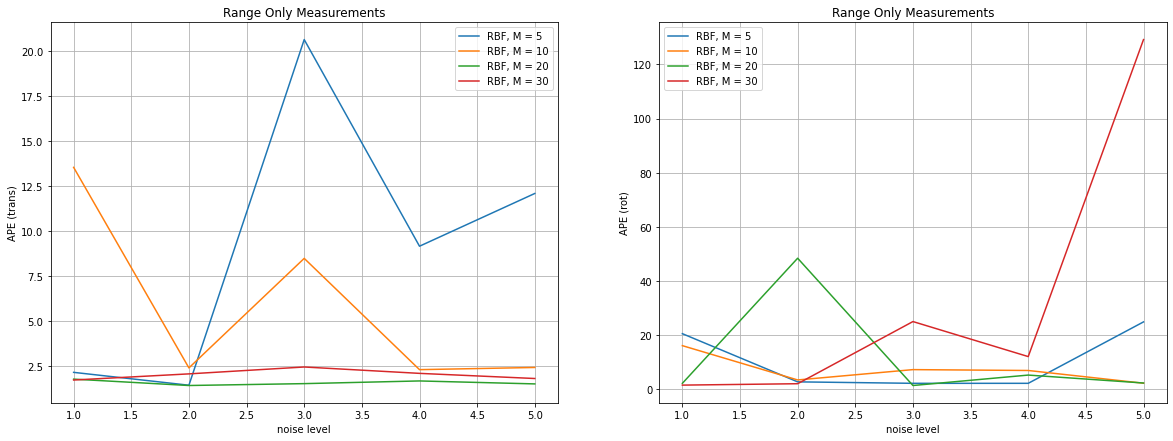

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
num_landm = [5, 10, 20, 30]

noise = np.arange(1, 6)
for i in range(results_trans.shape[1]):
    ax[0].plot(noise, results_trans[:, i], label = 'RBF, M = ' + str(num_landm[i]))
    ax[0].legend()
    ax[0].grid('black')
    ax[0].set_xlabel('noise level')
    ax[0].set_ylabel('APE (trans)')
    ax[0].set_title('Range Only Measurements')
    
    ax[1].plot(noise, results_rot[:, i], label = 'RBF, M = ' + str(num_landm[i]))
    ax[1].legend()
    ax[1].grid('black')
    ax[1].set_xlabel('noise level')
    ax[1].set_ylabel('APE (rot)')
    ax[1].set_title('Range Only Measurements')

In [16]:
np.array(odometry.states[1:11])#, np.array(odometry.states[:10])+np.array(odometry.motions[:10])

array([[ 2.52731892,  0.36200641,  0.44060008],
       [ 3.25373398,  0.572977  ,  0.38948858],
       [ 3.93968426,  0.79370143,  0.28893434],
       [ 4.54973988,  0.94851426,  0.24501191],
       [ 5.54068785,  1.25072336,  0.16300864],
       [ 6.51168279,  1.34874287,  0.0670283 ],
       [ 7.60583601,  1.55362468,  0.10003805],
       [15.12754903,  3.34762188,  1.20232216],
       [15.29252361,  4.60204357,  1.5544871 ],
       [14.94366171,  5.80403561,  1.82490413]])

In [17]:
model.prior_means[:10]

[array([2.15699628, 0.21197819, 0.44852944]),
 array([2.93214244, 0.48036556, 0.3928904 ]),
 array([3.91941479, 0.77905282, 0.28248002]),
 array([4.84739088, 1.00453528, 0.23196029]),
 array([5.90702728, 1.28739403, 0.12925126]),
 array([6.99891529, 1.49951535, 0.10083755]),
 array([8.0223155 , 1.78283776, 0.11496425]),
 array([9.27886939, 2.43107318, 0.49658111]),
 array([10.41018223,  3.54527817,  0.85975188]),
 array([11.19950397,  4.82362608,  1.05833625])]

In [18]:
model.states[:10]

array([[ 2.27864256,  0.2722652 ,  0.44990294],
       [ 3.05474743,  0.54242463,  0.39427224],
       [ 4.04064182,  0.83115822,  0.28382489],
       [ 4.96438267,  1.05032426,  0.23335302],
       [ 6.03381911,  1.3656993 ,  0.13061136],
       [ 7.11040139,  1.56236818,  0.10218331],
       [ 8.13631286,  1.86584493,  0.11631624],
       [ 9.38423252,  2.50190909,  0.49786765],
       [10.52117693,  3.59187005,  0.86105407],
       [11.3141428 ,  4.89608086,  1.05953313]])

In [19]:
model.b[300:].reshape(-1, 2), landscape.landmarks

(array([[ 6.54200597,  1.36002707],
        [ 7.80736414, -6.06406756],
        [-9.8279496 , -4.38658407],
        [-7.99389258,  1.33607624],
        [ 8.10215701,  0.97329082],
        [ 7.98913478,  6.94455757],
        [-9.35457719, -1.2027493 ],
        [ 6.16684237, -7.62167963],
        [-1.48649354, -5.90698284],
        [-6.95788406, -6.16608108],
        [-1.20281256,  6.18088094],
        [ 7.26690028, -8.46348889],
        [-3.00990526, -7.90223288],
        [-6.39447331, -2.49315901],
        [ 3.23405096, -8.5377894 ],
        [-8.21565702,  1.2222821 ],
        [ 8.30255221,  1.99396093],
        [-6.97417318,  7.78916788],
        [ 5.8180511 ,  6.86090545],
        [ 3.25948821,  5.50458738]]),
 array([[ 6.54230384,  1.35999629],
        [ 7.8073209 , -6.06452507],
        [-9.82951532, -4.38816772],
        [-7.99132568,  1.33736625],
        [ 8.10192792,  0.97400377],
        [ 7.9892356 ,  6.94722973],
        [-9.35505109, -1.20317407],
        [ 6.1668149 , -7.6